<a href="https://colab.research.google.com/github/RitikaHiremath/DataScience/blob/main/src/LSTM_Networks_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import os

def load_and_label_data(base_path, label, max_files=None):
    combined_100KHzdata = []
    combined_2000KHzdata = []

    # Initialize a counter
    file_counter = 0

    # Iterate over each timestamped folder
    for timestamp_folder in os.listdir(base_path):
        if max_files and file_counter >= max_files:
            break

        timestamp_folder_path = os.path.join(base_path, timestamp_folder, "raw")

        # Extract the full timestamp from the folder name and convert to datetime format
        timestamp = timestamp_folder.split('_')[0] + '_' + timestamp_folder.split('_')[1]
        timestamp = pd.to_datetime(timestamp, format='%Y.%m.%d_%H.%M.%S')

        # Load the 2000KHz data
        df_2000KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling2000KHz_AEKi-0.parquet"))
        mean_2000KHz = df_2000KHz.mean().to_frame().T
        mean_2000KHz['timestamp'] = timestamp
        mean_2000KHz['label'] = label

        # Load the 100KHz data
        df_100KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling100KHz_Irms_Grinding-Grinding spindle current L1-Grinding spindle current L2-Grinding spindle current L3-0.parquet"))
        mean_100KHz = df_100KHz.mean().to_frame().T
        mean_100KHz['timestamp'] = timestamp
        mean_100KHz['label'] = label

        # Append the mean data to the combined lists
        combined_100KHzdata.append(mean_100KHz)
        combined_2000KHzdata.append(mean_2000KHz)

        # Increment the counter
        file_counter += 1

    # Combine all the mean data into a single dataframe
    final_combined_100KHzdata = pd.concat(combined_100KHzdata, ignore_index=True)
    final_combined_2000KHzdata = pd.concat(combined_2000KHzdata, ignore_index=True)

    return final_combined_100KHzdata, final_combined_2000KHzdata

# Define the paths to the OK and NOK data directories
ok_data_path = '/content/gdrive/MyDrive/Data/OK_Measurements'
nok_data_path = '/content/gdrive/MyDrive/Data/NOK_Measurements'

# Load OK and NOK data
ok_100KHzdata, ok_2000KHzdata = load_and_label_data(ok_data_path, label=0)
nok_100KHzdata, nok_2000KHzdata = load_and_label_data(nok_data_path, label=1)

# Combine OK and NOK data
all_100KHzdata = pd.concat([ok_100KHzdata, nok_100KHzdata], ignore_index=True)
all_2000KHzdata = pd.concat([ok_2000KHzdata, nok_2000KHzdata], ignore_index=True)

# Print the first few rows of the combined data for inspection
print("Combined 100KHz Data Sample (Mean):")
print(all_100KHzdata.head())
print("\nCombined 2000KHz Data Sample (Mean):")
print(all_2000KHzdata.head())


Combined 100KHz Data Sample (Mean):
   Irms_Grinding_rate100000_clipping0_batch0  \
0                                   0.085166   
1                                   0.085681   
2                                   0.085834   
3                                   0.085607   
4                                   0.085260   

   Grinding spindle current L1_rate100000_clipping0_batch0  \
0                                          -0.000076         
1                                          -0.000062         
2                                          -0.000078         
3                                          -0.000086         
4                                          -0.000060         

   Grinding spindle current L2_rate100000_clipping0_batch0  \
0                                           0.000064         
1                                           0.000100         
2                                           0.000069         
3                                           0.000083  

In [3]:
from sklearn.preprocessing import StandardScaler

# Separate features and labels for 100KHz data
features_100KHz = all_100KHzdata.drop(columns=['timestamp', 'label'])  # Exclude timestamp and label
timestamps_100KHz = all_100KHzdata['timestamp']
labels_100KHz = all_100KHzdata['label']

# Normalize features for 100KHz data
scaler_100KHz = StandardScaler()
normalized_features_100KHz = scaler_100KHz.fit_transform(features_100KHz)

# Combine normalized features with timestamps and labels
normalized_100KHzdata = pd.DataFrame(normalized_features_100KHz, columns=features_100KHz.columns)
normalized_100KHzdata.insert(0, 'timestamp', timestamps_100KHz)  # Add timestamp column back
normalized_100KHzdata['label'] = labels_100KHz.values  # Add label column back

# Separate features and labels for 2000KHz data
features_2000KHz = all_2000KHzdata.drop(columns=['timestamp', 'label'])  # Exclude timestamp and label
timestamps_2000KHz = all_2000KHzdata['timestamp']
labels_2000KHz = all_2000KHzdata['label']

# Normalize features for 2000KHz data
scaler_2000KHz = StandardScaler()
normalized_features_2000KHz = scaler_2000KHz.fit_transform(features_2000KHz)

# Combine normalized features with timestamps and labels
normalized_2000KHzdata = pd.DataFrame(normalized_features_2000KHz, columns=features_2000KHz.columns)
normalized_2000KHzdata.insert(0, 'timestamp', timestamps_2000KHz)  # Add timestamp column back
normalized_2000KHzdata['label'] = labels_2000KHz.values  # Add label column back

print("Normalized 100KHz Data Sample:")
print(normalized_100KHzdata.head())
print(len(normalized_100KHzdata))
print("\nNormalized 2000KHz Data Sample:")
print(normalized_2000KHzdata.head())
print(len(normalized_2000KHzdata))


Normalized 100KHz Data Sample:
            timestamp  Irms_Grinding_rate100000_clipping0_batch0  \
0 2024-02-14 22:00:10                                  -1.213932   
1 2024-02-14 22:04:13                                  -1.059871   
2 2024-02-14 22:05:15                                  -1.014171   
3 2024-02-14 22:03:43                                  -1.082180   
4 2024-02-14 22:01:11                                  -1.185769   

   Grinding spindle current L1_rate100000_clipping0_batch0  \
0                                           0.410776         
1                                           1.275351         
2                                           0.286297         
3                                          -0.208334         
4                                           1.423043         

   Grinding spindle current L2_rate100000_clipping0_batch0  \
0                                          -0.126537         
1                                           1.918509         
2

In [4]:
import pandas as pd

# Concatenate the 100KHz and 2000KHz data
normalized_100KHzdata = normalized_100KHzdata.set_index('timestamp')
normalized_2000KHzdata = normalized_2000KHzdata.set_index('timestamp')

# Concatenate along columns
combined_data = pd.concat([normalized_100KHzdata, normalized_2000KHzdata], axis=1, join='inner').reset_index()

# Remove duplicate 'label' columns and keep the first one
combined_data = combined_data.loc[:, ~combined_data.columns.duplicated()]

# Ensure the label column is at the end
label = combined_data.pop('label')
combined_data['label'] = label

print("Combined Data Sample:")
print(combined_data.head())
print(len(combined_data))


Combined Data Sample:
            timestamp  Irms_Grinding_rate100000_clipping0_batch0  \
0 2024-02-14 22:00:10                                  -1.213932   
1 2024-02-14 22:04:13                                  -1.059871   
2 2024-02-14 22:05:15                                  -1.014171   
3 2024-02-14 22:03:43                                  -1.082180   
4 2024-02-14 22:01:11                                  -1.185769   

   Grinding spindle current L1_rate100000_clipping0_batch0  \
0                                           0.410776         
1                                           1.275351         
2                                           0.286297         
3                                          -0.208334         
4                                           1.423043         

   Grinding spindle current L2_rate100000_clipping0_batch0  \
0                                          -0.126537         
1                                           1.918509         
2         

In [10]:
import numpy as np

def create_labeled_sequences(data, sequence_length=10):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length, 1:-1].values  # Sequence of sensor readings (exclude timestamp and label)
        label = data.iloc[i+sequence_length - 1, -1]  # Label of the last point in the sequence
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define sequence length
sequence_length = 10

# Create labeled sequences for the combined data
X_combined, y_combined = create_labeled_sequences(combined_data, sequence_length)
print(f"Combined Sequences shape: {X_combined.shape}")
print(f"Combined Labels shape: {y_combined.shape}")


Combined Sequences shape: (48, 10, 5)
Combined Labels shape: (48,)


Epoch 1/5
5/5 [==============================] - 5s 261ms/step - loss: 0.6837 - accuracy: 0.6364 - val_loss: 0.6125 - val_accuracy: 1.0000
Epoch 2/5
5/5 [==============================] - 0s 19ms/step - loss: 0.5664 - accuracy: 0.9091 - val_loss: 0.5099 - val_accuracy: 1.0000
Epoch 3/5
5/5 [==============================] - 0s 19ms/step - loss: 0.4650 - accuracy: 0.8788 - val_loss: 0.4061 - val_accuracy: 1.0000
Epoch 4/5
5/5 [==============================] - 0s 20ms/step - loss: 0.3765 - accuracy: 0.8788 - val_loss: 0.2981 - val_accuracy: 1.0000
Epoch 5/5
5/5 [==============================] - 0s 22ms/step - loss: 0.3034 - accuracy: 0.8788 - val_loss: 0.2266 - val_accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


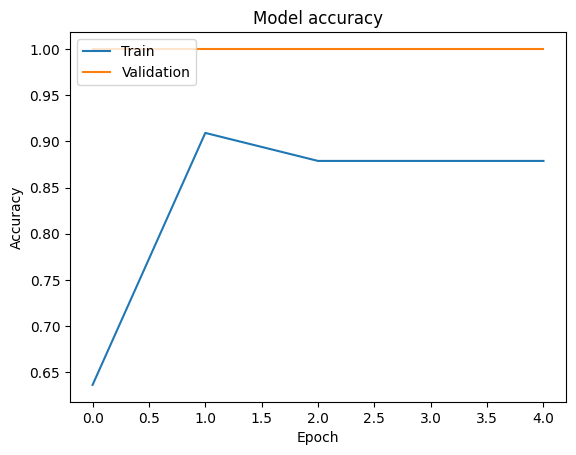

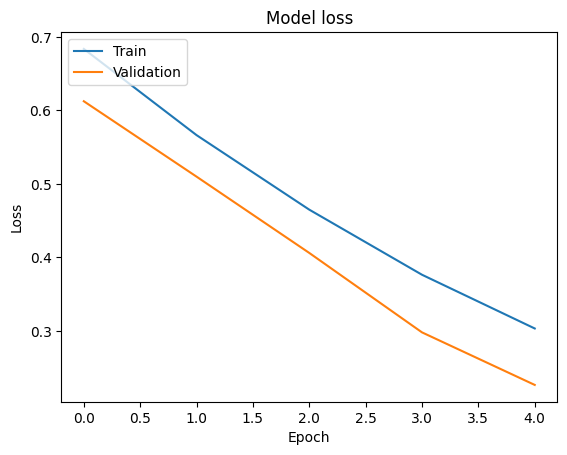

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Create an LSTM model with Dropout
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(LSTM(50))
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define input shape based on the combined data
input_shape_combined = (sequence_length, X_combined.shape[2])

# Create LSTM model for the combined data
model_combined = create_lstm_model(input_shape_combined)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model_combined.fit(
    X_combined, y_combined,
    epochs=5,
    batch_size=8,
    validation_split=0.3,
    callbacks=[early_stopping]
)

# Save the model
model_combined.save('lstm_model_combined_with_dropout.h5')

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
